In [1]:
import firedrake as fd
import matplotlib.pyplot as plt
import numpy as np
import ufl

import hydrogym.firedrake as hgym

from step_response import control_vec, LinearBDFSolver

output_dir = "../eig_output"
# output_dir = "../re40_med_eig_output"
output_dir = "../re100_med_eig_output"
# output_dir = "../re40_fine_eig_output"

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


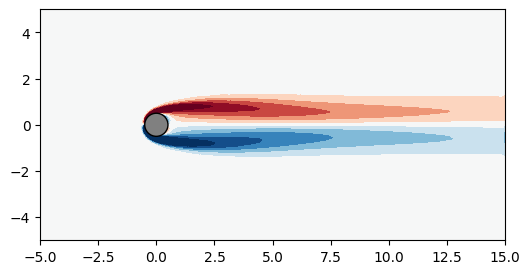

In [2]:
# 1. Steady base flow

flow = hgym.RotaryCylinder(
    Re=100,
    velocity_order=2,
    restart=f"{output_dir}/base.h5"
)

qB = flow.q.copy(deepcopy=True)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


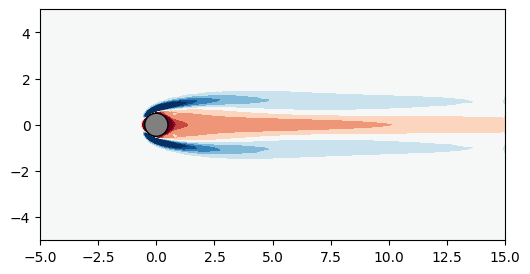

In [3]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure
qC = control_vec(flow)

flow.q.assign(qC)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
plt.show()

In [4]:
# 3. Step response of the flow
# Second-order BDF time-stepping
A = flow.linearize(qB)
J = A.J
W = A.function_space
bcs = A.bcs

dt = 0.01  # Time step
solver = LinearBDFSolver(W, J, order=2, dt=dt, bcs=bcs, q0=qC)

tf = 0.1
n_steps = int(tf // dt)
CL = np.zeros(n_steps)
CD = np.zeros(n_steps)

for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL[i], CD[i] = flow.get_observations()

    if i % 10 == 0:
        print(f"t={i*dt:.2f}, CL={CL[i]:.4f}, CD={CD[i]:.4f}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)
/tmp/ipykernel_64508/867670828.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  CL[i], CD[i] = flow.get_observations()


t=0.00, CL=1.7369, CD=-0.0014


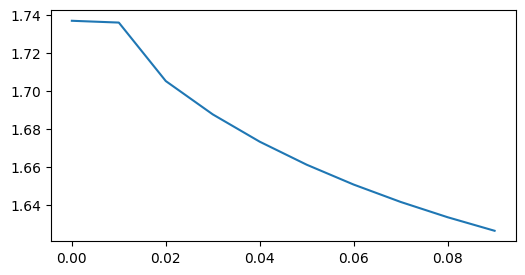

In [5]:
t = np.arange(n_steps) * dt
plt.figure(figsize=(6, 3))
plt.plot(t, CL, label="Lift")

# Load eigenvectors

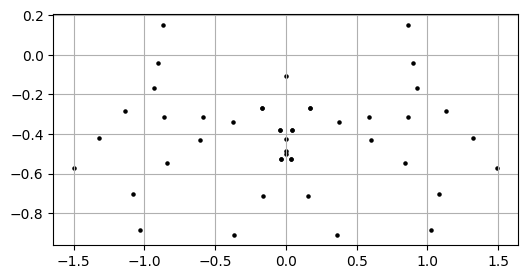

In [6]:
# Plot eigenvalues

evals = np.load(f"{output_dir}/evals.npy")

plt.figure(figsize=(6, 3))
plt.scatter(evals.imag, evals.real, s=5, c='k')
plt.grid()
plt.show()

In [7]:
# Load the set of eigenvectors
r = len(evals)
tol = 1e-10
V = []
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        V.append(q)

W = []
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        W.append(q)


# Sort by real part
sort_idx = np.argsort(-evals.real)
evals = evals[sort_idx]

V = [V[i] for i in sort_idx]
W = [W[i] for i in sort_idx]

In [8]:
for i in range(4):
    for j in range(4):
        print(i, j, flow.inner_product(V[i], W[j]))

0 0 (1.0000000000000024-1.6632735998979467e-16j)
0 1 (1.2344957811189264e-15-4.57815616988335e-16j)
0 2 (3.3434863764333217e-15+7.32985000752545e-15j)
0 3 (-2.2666567787207187e-15+5.03356105169446e-16j)
1 0 (1.2344957811189264e-15+4.57815616988335e-16j)
1 1 (1.0000000000000024+1.6632735998979467e-16j)
1 2 (-2.2666567787207187e-15-5.03356105169446e-16j)
1 3 (3.3434863764333217e-15-7.32985000752545e-15j)
2 0 (3.385087301141863e-16+8.820928883295196e-16j)
2 1 (-2.856969660140928e-15-8.535385043963482e-16j)
2 2 (0.9999999999999984-3.474344919971112e-16j)
2 3 (1.7492310327809051e-15+6.184987147005855e-15j)
3 0 (-2.856969660140928e-15+8.535385043963482e-16j)
3 1 (3.385087301141863e-16-8.820928883295196e-16j)
3 2 (1.7492310327809051e-15-6.184987147005855e-15j)
3 3 (0.9999999999999984+3.474344919971112e-16j)


In [9]:

def orthogonal_project(q, V, W):
    """Orthogonal projection of q onto the subspace spanned by Vu"""
    for i in range(len(V)):
        q_dot_w = flow.inner_product(q, W[i])
        # q_dot_w = flow.inner_product(q, V[i])
        norm_w = 1
        alpha = q_dot_w / norm_w
        # print(i, alpha)
        q.assign(q - V[i] * alpha)
    return q

# Unstable subspace
unstable_idx = np.where(evals.real > 0)[0]
Vu = [V[i] for i in unstable_idx]
Wu = [W[i] for i in unstable_idx]

(2.629643178675104+0j)
(30.606050280438534+0j)


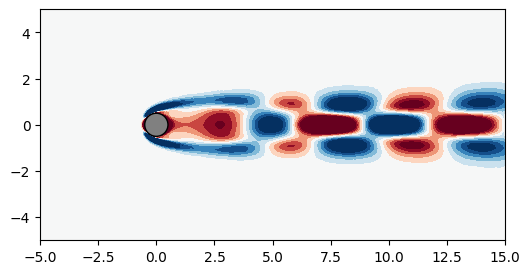

In [10]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure
qCs = qC.copy(deepcopy=True)
# idx = 2
# qCs.assign(0.5 * (V[idx] + V[idx+1]))
# print(abs(qCs.dat.data[0].imag).max())
orthogonal_project(qCs, Vu, Wu)

print(flow.inner_product(qC, qC))
print(flow.inner_product(qCs, qCs))

flow.q.assign(qCs)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
plt.show()

In [11]:
# 3. Step response of the flow in the stable subspace
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

dt = 0.01  # Time step
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=qCs)

tf = 50
# tf = 0.1
n_steps = int(tf // dt)
CL = np.zeros(n_steps)
CD = np.zeros(n_steps)

for i in range(n_steps):
    q = solver.step()
    orthogonal_project(q, Vu, Wu)
    flow.q.assign(q)
    CL[i], CD[i] = flow.get_observations()

    if i % 10 == 0:
        print(f"t={i*dt:.2f}, CL={CL[i]:.4f}, CD={CD[i]:.4f}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)
/tmp/ipykernel_64508/3189434382.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  CL[i], CD[i] = flow.get_observations()


t=0.00, CL=1.6810, CD=-0.0014
t=0.10, CL=1.5578, CD=-0.0000
t=0.20, CL=1.5153, CD=-0.0000
t=0.30, CL=1.4987, CD=-0.0000
t=0.40, CL=1.4912, CD=-0.0000
t=0.50, CL=1.4844, CD=-0.0000
t=0.60, CL=1.4733, CD=-0.0000
t=0.70, CL=1.4553, CD=-0.0000
t=0.80, CL=1.4294, CD=-0.0000
t=0.90, CL=1.3955, CD=-0.0000
t=1.00, CL=1.3542, CD=-0.0000
t=1.10, CL=1.3061, CD=-0.0000
t=1.20, CL=1.2524, CD=-0.0000
t=1.30, CL=1.1938, CD=-0.0000
t=1.40, CL=1.1314, CD=-0.0000
t=1.50, CL=1.0659, CD=-0.0000
t=1.60, CL=0.9980, CD=-0.0000
t=1.70, CL=0.9284, CD=-0.0000
t=1.80, CL=0.8577, CD=-0.0000
t=1.90, CL=0.7863, CD=-0.0000
t=2.00, CL=0.7148, CD=-0.0000
t=2.10, CL=0.6435, CD=-0.0000
t=2.20, CL=0.5728, CD=-0.0000
t=2.30, CL=0.5031, CD=-0.0000
t=2.40, CL=0.4347, CD=-0.0000
t=2.50, CL=0.3678, CD=-0.0000
t=2.60, CL=0.3028, CD=-0.0000
t=2.70, CL=0.2398, CD=-0.0000
t=2.80, CL=0.1791, CD=-0.0000
t=2.90, CL=0.1210, CD=-0.0000
t=3.00, CL=0.0655, CD=-0.0000
t=3.10, CL=0.0128, CD=-0.0000
t=3.20, CL=-0.0368, CD=-0.0000
t=3.30, C

KeyboardInterrupt: 

[[ 0.00000000e+00  3.86746705e-05  1.28404309e+00]
 [ 1.00000000e-02  1.68098202e+00 -1.41382858e-03]
 [ 2.00000000e-02  1.67946119e+00 -1.20312065e-04]
 ...
 [ 2.99970000e+02  5.25939823e-07  4.45486362e-10]
 [ 2.99980000e+02  5.33629179e-07  4.32401061e-10]
 [ 2.99990000e+02  5.42406394e-07  7.63781077e-12]]


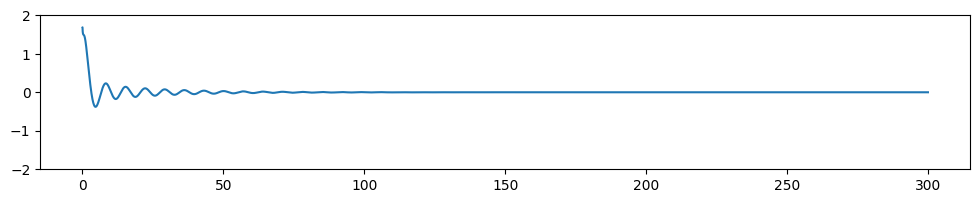

In [26]:
# Load data from model_reduction/step_response.py
step_response = np.load("output/re100_subspace_response.npy")
print(step_response)
t_full, CL_full = step_response[:, 0], step_response[:, 1]

tf = 300
t_idx = np.where(t_full < tf)[0][1:]
t = t_full[t_idx]
CL = CL_full[t_idx]

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(t, CL, label="Full operator")
# ax.plot(t_full, CL_full, label="Full operator")
# ax.plot(np.arange(0, tf-dt, dt), CL, label="Stable subspace")
ax.set_ylim([-2, 2])
# ax.set_xlim([0, 100])
plt.show()

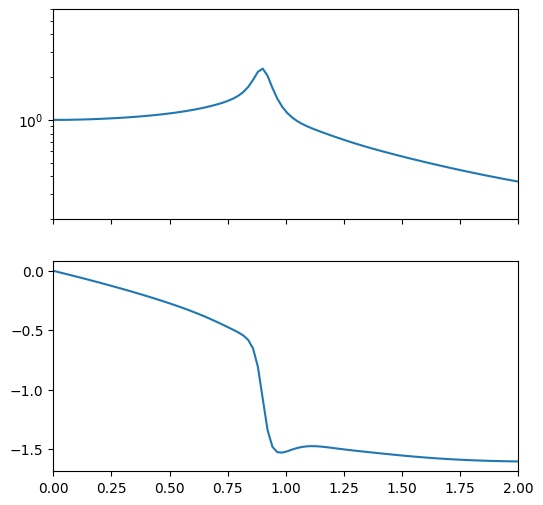

In [27]:
# Fourier transform of the step response
# Compare to transfer_function.ipynb

fs = 1 / (t[1] - t[0])

n = len(CL)
f = 2 * np.pi * np.fft.fftfreq(n, d=1/fs)
CL_fft = np.sqrt(1 / 2 * np.pi) * np.fft.fft(CL) / fs

CL_fft = CL_fft / CL_fft[0]

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(f[:n//2], np.abs(CL_fft[:n//2]))
ax[0].set_ylim(0.2, 6)
ax[1].plot(f[:n//2], np.angle(CL_fft[:n//2]))
ax[1].set_xlim(0, 2)
plt.show()


[[ 0.00000000e+00  9.44878059e+03  3.08715940e+01]
 [ 1.00000000e-02  2.83484023e+03  4.17487820e+00]
 [ 2.00000000e-02 -2.57028801e+02 -2.99446795e+00]
 ...
 [ 9.96000000e+00  1.00970924e+02 -2.47057975e-03]
 [ 9.97000000e+00  1.01930266e+02 -2.46559288e-03]
 [ 9.98000000e+00  1.02887825e+02 -2.46034368e-03]]


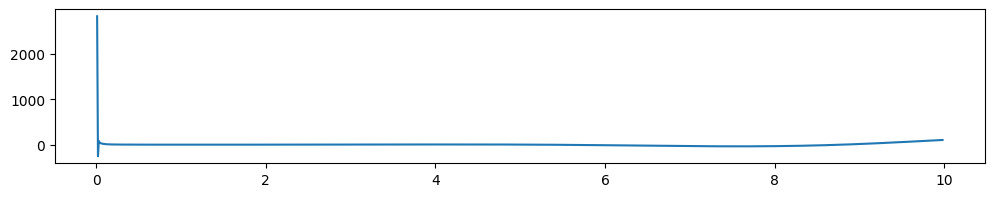

In [31]:
# Load data from model_reduction/step_response.py
step_response = np.load("impulse_output/re100_adj_response.npy")
print(step_response)
t_full, CL_full = step_response[:, 0], step_response[:, 1]

tf = 300
t_idx = np.where(t_full < tf)[0][1:]
t = t_full[t_idx]
CL = CL_full[t_idx]

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(t, CL, label="Full operator")
# ax.plot(t_full, CL_full, label="Full operator")
# ax.plot(np.arange(0, tf-dt, dt), CL, label="Stable subspace")
# ax.set_ylim([-2, 2])
# ax.set_xlim([0, 100])
plt.show()